#Data Loading

In [1]:
#prod
#!pip install imbalanced-learn
!pip install lightgbm
!pip install rfpimp

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from statistics import mean
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import rfpimp
import lightgbm as lgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10668 sha256=b84e03ea9ac02778ce93072af9211b6c07c7e962028a3094ca115553a80f9ef5
  Stored in directory: /root/.cache/pip/wheels/8a/42/e5/d2e9d77df351103d7d16dbc82ce6090cb2f71cee74b7380b7b
Successfully built rfpimp


In [2]:
#prod
#Data stored in Google Drive, must authenticate to pull data
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#prod
#01_M02_DC_train
#https://drive.google.com/file/d/1DO8bKxsTZe8gQ_zNnf6X1-9xlsWw37y2/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1DO8bKxsTZe8gQ_zNnf6X1-9xlsWw37y2'})
fileDownloaded.GetContentFile('01_M02_DC_train.csv')

#01_M02_train_fault_data
#https://drive.google.com/file/d/1dppx60e2tdu4nm2XvZ1lRlMVPnVI4cvV/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1dppx60e2tdu4nm2XvZ1lRlMVPnVI4cvV'})
fileDownloaded.GetContentFile('01_M02_train_fault_data.csv')

#01_M02_DC_train_ttf
#https://drive.google.com/file/d/1xBhlyjDhO1t_jXJLsKxP-SXD0XhKtmAU/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1xBhlyjDhO1t_jXJLsKxP-SXD0XhKtmAU'})
fileDownloaded.GetContentFile('01_M02_DC_train_ttf.csv')

#loading into CSVs
df_train = pd.read_csv('01_M02_DC_train.csv', delimiter=',')
df_train.set_index('time')

df_fault = pd.read_csv('01_M02_train_fault_data.csv', delimiter=',')
df_fault.set_index('time')

df_ttf = pd.read_csv('01_M02_DC_train_ttf.csv', delimiter=',')
df_ttf.set_index('time')


# #03_M02_DC_train
# #https://drive.google.com/file/d/1Mho3WwCHX5JUo5IZwibV5MNBvJr_ZRhJ/view?usp=share_link
# fileDownloaded = drive.CreateFile({'id':'1Mho3WwCHX5JUo5IZwibV5MNBvJr_ZRhJ'})
# fileDownloaded.GetContentFile('03_M02_DC_train.csv')

# #03_M02_train_fault_data
# #https://drive.google.com/file/d/1-uZaGxkZBF-wrg5mBIL1WIL187Bc_cUt/view?usp=sharing
# fileDownloaded = drive.CreateFile({'id':'1-uZaGxkZBF-wrg5mBIL1WIL187Bc_cUt'})
# fileDownloaded.GetContentFile('03_M02_train_fault_data.csv')

# #03_M02_DC_train_ttf
# #https://drive.google.com/file/d/1IpBcjBap0LCVqKLb2Uwk3biTuXlpB4qF/view?usp=sharing
# fileDownloaded = drive.CreateFile({'id':'1IpBcjBap0LCVqKLb2Uwk3biTuXlpB4qF'})
# fileDownloaded.GetContentFile('03_M02_DC_train_ttf.csv')

# #loading into CSVs
# df_train = pd.read_csv('03_M02_DC_train.csv', delimiter=',')
# df_train.set_index('time')

# df_fault = pd.read_csv('03_M02_train_fault_data.csv', delimiter=',')
# df_fault.set_index('time')

# df_ttf = pd.read_csv('03_M02_DC_train_ttf.csv', delimiter=',')
# df_ttf.set_index('time')

,TTF_FlowCool Pressure Dropped Below Limit,TTF_Flowcool Pressure Too High Check Flowcool Pump,TTF_Flowcool leak
time,,,
3283834,623234.0,9146470.0,632514.0
3283838,623230.0,9146466.0,632510.0
3283842,623226.0,9146462.0,632506.0
3283846,623222.0,9146458.0,632502.0
3283850,623218.0,9146454.0,632498.0
...,...,...,...
39789824,NaN,NaN,NaN
39789828,NaN,NaN,NaN
39789832,NaN,NaN,NaN


# Proprocessing

In [4]:
#prod
#Make sure the TTFs are all divisible by 4, and subtract mod 4 if not
df_ttf['TTF_FlowCool Pressure Dropped Below Limit'] = df_ttf['TTF_FlowCool Pressure Dropped Below Limit'].sub(df_ttf['TTF_FlowCool Pressure Dropped Below Limit'] % 4)
df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'] = df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'].sub(df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'] % 4)
df_ttf['TTF_Flowcool leak'] = df_ttf['TTF_Flowcool leak'].sub(df_ttf['TTF_Flowcool leak'] % 4)

#set failure time to mod 4 as well so the time index matches other datasets
df_fault['time'] = df_fault['time'].sub(df_fault['time'] % 4)

# #sanity check
# print(df_ttf.loc[df_ttf['TTF_FlowCool Pressure Dropped Below Limit'].isin([1, 2, 3])])
# print(df_ttf.loc[df_ttf['TTF_Flowcool Pressure Too High Check Flowcool Pump'].isin([1, 2, 3])])
# print(df_ttf.loc[df_ttf['TTF_Flowcool leak'].isin([1, 2, 3])])

#join the ttf and training data together on time
df = pd.concat([df_train, df_ttf], axis=1, join = 'inner')
df.columns = ['time', 'Tool', 'stage', 'Lot', 'runnum', 'recipe', 'recipe_step','IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE','FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK','FIXTURETILTANGLE', 'ROTATIONSPEED', 'ACTUALROTATIONANGLE','FIXTURESHUTTERPOSITION', 'ETCHSOURCEUSAGE', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'ACTUALSTEPDURATION', 'time_drop','TTF_FlowCool Pressure Dropped Below Limit','TTF_Flowcool Pressure Too High Check Flowcool Pump','TTF_Flowcool leak']
#drop excess "time" column by position
df = df.drop(df.columns[24],axis = 1)

#FSP of 1 is the only important data
df = df.loc[df['FIXTURESHUTTERPOSITION'] == 1]
#drop NaNs that are present at the end of ttf (no more failures)
df = df.dropna(subset=['TTF_FlowCool Pressure Dropped Below Limit','TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak'], how='all')
#drop duplicates ignoring the time and TTF columns
df.drop_duplicates(subset=df.columns.difference(['time', 'TTF_FlowCool Pressure Dropped Below Limit', 'TTF_Flowcool Pressure Too High Check Flowcool Pump',	'TTF_Flowcool leak']))

#Make 3 dataframes, one for each fail type
df_f1 = df.drop(['TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f1 = df_f1.dropna()
df_f2 = df.drop(['TTF_FlowCool Pressure Dropped Below Limit',          'TTF_Flowcool leak', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f2 = df_f2.dropna()
df_f3 = df.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'TTF_Flowcool Pressure Too High Check Flowcool Pump', "time", "Tool", "ROTATIONSPEED", "FIXTURESHUTTERPOSITION"],axis = 1)
df_f3 = df_f3.dropna()

#stage, recipe, and recipe step are categorical and need to be encoded as such, but adds complexity. Wu dropped them. include OHE in Proprocess_data function

In [5]:
#prod
def PreProcess_Data(df_f1, df_f2, df_f3, numKept, numFail):
    #only keep the data within 6000 seconds of a failure  to closer analyze the data
    df_f1 = df_f1.loc[df['TTF_FlowCool Pressure Dropped Below Limit'] < numKept]
    df_f2 = df_f2.loc[df['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numKept]
    df_f3 = df_f3.loc[df['TTF_Flowcool leak'] < numKept]

    # df_f1['IsFailure'] = np.where(df_f1['TTF_FlowCool Pressure Dropped Below Limit'] < numFail, True, False)
    # df_f2['IsFailure'] = np.where(df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numFail, True, False)
    # df_f3['IsFailure'] = np.where(df_f3['TTF_Flowcool leak'] < numFail, True, False)
    df_f1.loc[df_f1['TTF_FlowCool Pressure Dropped Below Limit'] < numFail, 'IsFailure'] = 1
    df_f1.loc[df_f1['TTF_FlowCool Pressure Dropped Below Limit'] >= numFail, 'IsFailure'] = 0

    df_f2.loc[df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] < numFail, 'IsFailure'] = 1
    df_f2.loc[df_f2['TTF_Flowcool Pressure Too High Check Flowcool Pump'] >= numFail, 'IsFailure'] = 0

    df_f3.loc[df_f3['TTF_Flowcool leak'] < numFail, 'IsFailure'] = 1
    df_f3.loc[df_f3['TTF_Flowcool leak'] >= numFail, 'IsFailure'] = 0

    return df_f1, df_f2, df_f3

# RFC Pickle

In [ ]:
#prod
#get data with 5000 points from 0 as relevant and 250 point from 0 being fail data
df1, df2, df3 = PreProcess_Data(df_f1, df_f2, df_f3, 5000, 250)

#drop categorical columns
df_temp = df1[['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure']]
df1 = df1.drop(['stage', 'recipe', 'recipe_step', 'TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)

#implement a standard scaler to normalize the dataset, but not scaling the target values.
scaler = StandardScaler()
scaler.fit(df1)
df1_scaled = scaler.transform(df1)
df1_scaled = pd.DataFrame(df1_scaled, columns = df1.columns)
#reintroduce the target values
df_index = pd.DataFrame(df_temp.index.values)
df1_scaled = pd.concat([df1_scaled, df_index], axis=1, join = 'inner')
df1_scaled = df1_scaled.set_index(0)
df1_scaled = pd.concat([df1_scaled, df_temp ], axis=1, join = 'inner')

#get indices where TTF is 0 from df1
zero_index = df1_scaled.index[df1_scaled['TTF_FlowCool Pressure Dropped Below Limit'] == 0].tolist()
#get data from the third to last 0, until the second to last 0. This will be the test data
df_stream = df1_scaled.loc[zero_index[-3] : zero_index[-2]]

#train data is all data until the third to last 0
df_stream_train = df1_scaled.loc[:zero_index[-3]]

df_stream_xTrain = df_stream_train.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTrain = df_stream_train['IsFailure']
#Use SMOTE to oversample the minority class
oversample = SMOTE()
df_stream_xTrain_smote, df_stream_yTrain_smote = oversample.fit_resample(df_stream_xTrain, df_stream_yTrain)

#test data is from the last uninterupted count to 0 in the dataset
df_stream_test = df_stream.loc[df_stream[df_stream['TTF_FlowCool Pressure Dropped Below Limit'] > df_stream['TTF_FlowCool Pressure Dropped Below Limit'].shift().rolling(2, min_periods=1).min()].tail(1).index.item():]

df_stream_xTest = df_stream_test.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTest = df_stream_test['IsFailure']

RANDOM FOREST RESULTS: 

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       991
         1.0       0.50      1.00      0.66        63

    accuracy                           0.94      1054
   macro avg       0.75      0.97      0.81      1054
weighted avg       0.97      0.94      0.95      1054



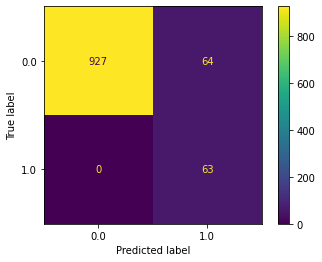

In [ ]:
#LOADED MODEL FROM PICKLE
import pickle
filename = 'Data_606_RFC.sav'

#https://drive.google.com/file/d/1E98XDFCSWyiSZntCud0BEyBSTCtDUtKV/view?usp=share_link
fileDownloaded = drive.CreateFile({'id':'1E98XDFCSWyiSZntCud0BEyBSTCtDUtKV'})
fileDownloaded.GetContentFile(filename)

RFC = pickle.load(open(filename, 'rb'))

print("RANDOM FOREST RESULTS: \n")        
y_pred_stream = RFC.predict(df_stream_xTest)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df_stream_yTest, y_pred_stream),
                               display_labels=RFC.classes_)
disp.plot()
print(classification_report(df_stream_yTest, y_pred_stream))

In [ ]:
#next, regression
RFR = RandomForestRegressor(n_estimators=100, n_jobs=-1)
RFR.fit(df_stream_xTrain, df_stream_train['TTF_FlowCool Pressure Dropped Below Limit'])
y_prediction = RFR.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'],y_prediction)
print('r2 score is:',score)
print('mean_sqrd_error is:',mean_squared_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -1.5619042115351927
mean_sqrd_error is: 3495836.4766072105
root_mean_squared error of is: 1869.7156138320101


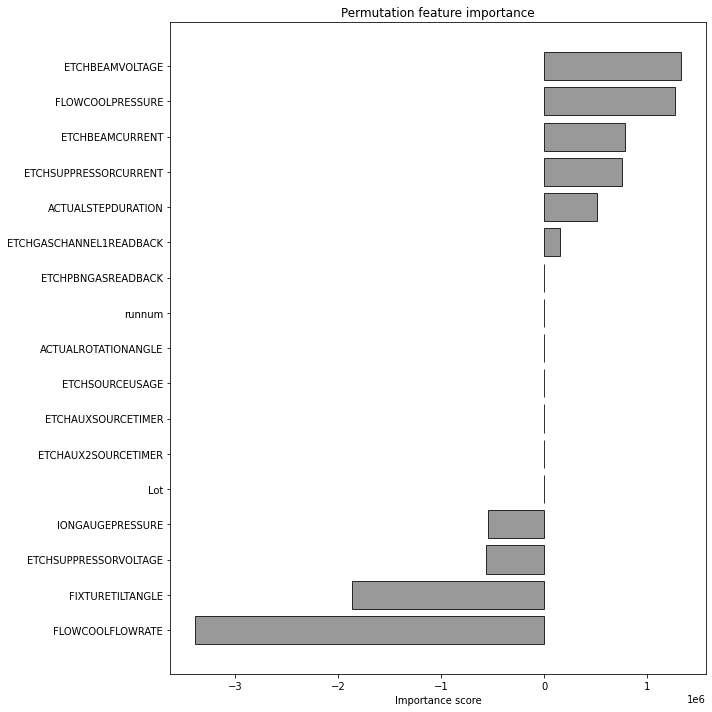

In [ ]:
imp = rfpimp.importances(RFR, df_stream_xTest, df_stream_yTest)

fig, ax = plt.subplots(figsize=(6, 3))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k') #find how to only see top 10 bars
ax.set_xlabel('Importance score')
ax.set_title('Permutation feature importance')
plt.gca().invert_yaxis()
fig.set_size_inches(10, 10)

fig.tight_layout()

In [ ]:
#loop through the test data, inserting 1 row at a time
for i in range(len(df_stream_xTest)):
    #if the RFC predicts a fail with over 55% confidence
    predictions = RFC.predict_proba(df_stream_xTest.iloc[[i]])
    if predictions[0][1] > 0.55:
        #output the estimate of the regressor
        print("The regressor estimated a TTF of:" + str(RFR.predict(df_stream_xTest.iloc[[i]])[0]))
        #versus the true TTF
        print(df_stream_test.iloc[[i]])
        #and the prediction that the RFC made
        print(predictions[0][1])
        print('--------------------------------------------------------')

The regressor estimated a TTF of:2232.12
             Lot    runnum  IONGAUGEPRESSURE  ETCHBEAMVOLTAGE  \
3000472 -0.14556  0.295618         -0.032993         0.974211   

         ETCHBEAMCURRENT  ETCHSUPPRESSORVOLTAGE  ETCHSUPPRESSORCURRENT  \
3000472         0.495865               0.890604               0.095097   

         FLOWCOOLFLOWRATE  FLOWCOOLPRESSURE  ETCHGASCHANNEL1READBACK  \
3000472          0.902661          0.068823                -0.606006   

         ETCHPBNGASREADBACK  FIXTURETILTANGLE  ACTUALROTATIONANGLE  \
3000472           -0.596428          0.260321            -0.451982   

         ETCHSOURCEUSAGE  ETCHAUXSOURCETIMER  ETCHAUX2SOURCETIMER  \
3000472        -0.569799           -0.533308            -0.533308   

         ACTUALSTEPDURATION  TTF_FlowCool Pressure Dropped Below Limit  \
3000472            1.189286                                      480.0   

         IsFailure  
3000472        0.0  
0.5784333117920063
--------------------------------------------

# RFC New

In [6]:
#prod
#get data with 5000 points from 0 as relevant and 250 point from 0 being fail data
df1, df2, df3 = PreProcess_Data(df_f1, df_f2, df_f3, 86400, 10000)

#drop categorical columns and highly coorelated columns
df_temp = df1[['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure']]
df1 = df1.drop(['stage', 'recipe', 'recipe_step',  'Lot', 'runnum', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)

#implement a standard scaler to normalize the dataset, but not scaling the target values.
scaler = StandardScaler()
scaler.fit(df1)
df1_scaled = scaler.transform(df1)
df1_scaled = pd.DataFrame(df1_scaled, columns = df1.columns)
#reintroduce the target values
df_index = pd.DataFrame(df_temp.index.values)
df1_scaled = pd.concat([df1_scaled, df_index], axis=1, join = 'inner')
df1_scaled = df1_scaled.set_index(0)
df1_scaled = pd.concat([df1_scaled, df_temp ], axis=1, join = 'inner')

#get indices where TTF is 0 from df1
zero_index = df1_scaled.index[df1_scaled['TTF_FlowCool Pressure Dropped Below Limit'] == 0].tolist()
#get data from the third to last 0, until the second to last 0. This will be the test data
df_stream = df1_scaled.loc[zero_index[-5] : zero_index[-4]]
#zero_index of 9-10, 17-18, 22-23 are the large slices of data

#train data is all data until the third to last 0
df_stream_train = df1_scaled
df_stream_train.drop(df_stream.index, axis = 0, inplace = True)

df_stream_xTrain = df_stream_train.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTrain = df_stream_train['IsFailure']
#Use SMOTE to oversample the minority class
oversample = SMOTE()
df_stream_xTrain_smote, df_stream_yTrain_smote = oversample.fit_resample(df_stream_xTrain, df_stream_yTrain)

#test data is from the last uninterupted count to 0 in the dataset
df_stream_test = df_stream.loc[df_stream[df_stream['TTF_FlowCool Pressure Dropped Below Limit'] > df_stream['TTF_FlowCool Pressure Dropped Below Limit'].shift().rolling(2, min_periods=1).min()].tail(1).index.item():]

df_stream_xTest = df_stream_test.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTest = df_stream_test['IsFailure']

RANDOM FOREST RESULTS: 

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89     14711
         1.0       0.06      0.05      0.05      1819

    accuracy                           0.81     16530
   macro avg       0.47      0.47      0.47     16530
weighted avg       0.79      0.81      0.80     16530



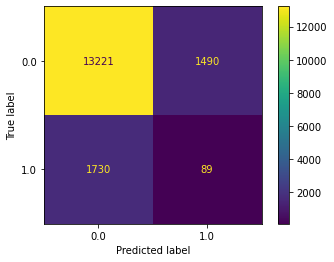

In [ ]:
#MAKING A NEW RFC
RFC = RandomForestClassifier(n_estimators=100, n_jobs = -1, criterion = 'entropy', max_depth = 5, random_state = 25)
#RFC.fit(df_stream_xTrain, df_stream_yTrain)
RFC.fit(df_stream_xTrain_smote, df_stream_yTrain_smote)

print("RANDOM FOREST RESULTS: \n")        
y_pred_stream = RFC.predict(df_stream_xTest)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df_stream_yTest, y_pred_stream),
                               display_labels=RFC.classes_)
disp.plot()
print(classification_report(df_stream_yTest, y_pred_stream))

# KMeans

In [ ]:
#import birch
from sklearn.cluster import Birch

#prod
#get data with 5000 points from 0 as relevant and 250 point from 0 being fail data
df1, df2, df3 = PreProcess_Data(df_f1, df_f2, df_f3, 86400, 10000)

#drop categorical columns and highly coorelated columns
df_temp = df1[['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure']]
df1 = df1.drop(['stage', 'recipe', 'recipe_step',  'Lot', 'runnum', 'ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER', 'TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)

#implement a standard scaler to normalize the dataset, but not scaling the target values.
scaler = StandardScaler()
scaler.fit(df1)
df1_scaled = scaler.transform(df1)
df1_scaled = pd.DataFrame(df1_scaled, columns = df1.columns)
#reintroduce the target values
df_index = pd.DataFrame(df_temp.index.values)
df1_scaled = pd.concat([df1_scaled, df_index], axis=1, join = 'inner')
df1_scaled = df1_scaled.set_index(0)
df1_scaled = pd.concat([df1_scaled, df_temp ], axis=1, join = 'inner')

#get indices where TTF is 0 from df1
zero_index = df1_scaled.index[df1_scaled['TTF_FlowCool Pressure Dropped Below Limit'] == 0].tolist()
#get data from the third to last 0, until the second to last 0. This will be the test data
df_stream = df1_scaled.loc[zero_index[15] : zero_index[16]]
#zero_index of 6-7, 10-11, 15-16, 23-24 are the large slices of data (-5 to -4 good also)

#train data is all data until the third to last 0
df_stream_train = df1_scaled
df_stream_train.drop(df_stream.index, axis = 0, inplace = True)

df_stream_xTrain = df_stream_train.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTrain = df_stream_train['IsFailure']
#Use SMOTE to oversample the minority class
# oversample = SMOTE()
# df_stream_xTrain_smote, df_stream_yTrain_smote = oversample.fit_resample(df_stream_xTrain, df_stream_yTrain)

#test data is from the last uninterupted count to 0 in the dataset
df_stream_test = df_stream.loc[df_stream[df_stream['TTF_FlowCool Pressure Dropped Below Limit'] > df_stream['TTF_FlowCool Pressure Dropped Below Limit'].shift().rolling(2, min_periods=1).min()].tail(1).index.item():]

df_stream_xTest = df_stream_test.drop(['TTF_FlowCool Pressure Dropped Below Limit', 'IsFailure'], axis=1)
df_stream_yTest = df_stream_test['IsFailure']

In [ ]:
from sklearn.cluster import KMeans
#make birch model
KMeans_model = KMeans(n_clusters=2)
# fit the model
cluster_fit = KMeans_model.fit(df_stream_xTrain)
#cluster_fit.labels_ to get the predictions of the train data

#predict the test data with the trained model
cluster_pred = cluster_fit.predict(df_stream_xTest)

#print where the model is predicting a failure in the slice of test data
np.unique(cluster_pred, return_counts=True)

(array([0, 1], dtype=int32), array([ 4851, 11446]))

In [ ]:
j = np.where(cluster_pred == 1)

print(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'].iloc[[j[0][0]]])
print(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'].iloc[[[0][0]]])
j[0][0]

2627020    86388.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64
2627020    86388.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64


0

In [ ]:
j = np.where(cluster_pred == 1)
for i in range(len(j[0])):
    print(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'].iloc[[j[0][i]]])

# LSTM

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [55]:
#LSTM Data transforming
df_stream_xTrain_ri = df_stream_xTrain.reset_index()
df_stream_xTrain_ri = df_stream_xTrain_ri.drop('index', axis = 1)

df_stream_y_LSTM = df_stream_train['TTF_FlowCool Pressure Dropped Below Limit']
df_stream_y_LSTM = df_stream_y_LSTM.reset_index()
df_stream_y_LSTM = df_stream_y_LSTM.drop('index', axis = 1)

df_stream_xTrain_LSTM = df_stream_xTrain_ri.loc[:int(len(df_stream_xTrain_ri) * 0.8)]
df_stream_yTrain_LSTM = df_stream_y_LSTM.loc[:int(len(df_stream_y_LSTM) * 0.8)]

df_stream_xVal_LSTM = df_stream_xTrain_ri.loc[int(len(df_stream_xTrain_ri) * 0.8):]
df_stream_yVal_LSTM = df_stream_y_LSTM.loc[int(len(df_stream_y_LSTM) * 0.8):]

df_stream_xTest_ri = df_stream_xTest.reset_index()
df_stream_xTest_LSTM = df_stream_xTest_ri.drop('index', axis = 1)

df_stream_yTest_LSTM = df_stream_test['TTF_FlowCool Pressure Dropped Below Limit']
df_stream_yTest_LSTM = df_stream_yTest_LSTM.reset_index()
df_stream_yTest_LSTM = df_stream_yTest_LSTM.drop('index', axis = 1)

df_stream_xTrain_LSTM = np.array(df_stream_xTrain_LSTM)
train_X = df_stream_xTrain_LSTM.reshape(df_stream_xTrain_LSTM.shape[0],1,df_stream_xTrain_LSTM.shape[1])
df_stream_yTrain_LSTM = np.array(df_stream_yTrain_LSTM)

df_stream_xVal_LSTM = np.array(df_stream_xVal_LSTM)
val_X = df_stream_xVal_LSTM.reshape(df_stream_xVal_LSTM.shape[0],1,df_stream_xVal_LSTM.shape[1])
df_stream_yVal_LSTM = np.array(df_stream_yVal_LSTM)

df_stream_xTest_LSTM = np.array(df_stream_xTest_LSTM)
test_X = df_stream_xTest_LSTM.reshape(df_stream_xTest_LSTM.shape[0],1,df_stream_xTest_LSTM.shape[1])
df_stream_yTest_LSTM = np.array(df_stream_yTest_LSTM)

In [40]:
model1 = Sequential()
model1.add(LSTM(50, activation ='relu', input_shape=(1,10), return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(50, activation ='relu', return_sequences = False))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(optimizer = 'adam', loss ='mse', metrics=['RootMeanSquaredError'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 50)             12200     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32,451
Trainable params: 32,451
Non-trainable params: 0
_________________________________________________________________


In [43]:
history1 = model1.fit(train_X, df_stream_yTrain_LSTM, epochs=20, batch_size =16, validation_data =(val_X, df_stream_yVal_LSTM), verbose =1, shuffle=False)

Epoch 1/20
10993/10993 [==============================] - 59s 5ms/step - loss: 1267358848.0000 - mean_squared_error: 1267358848.0000 - val_loss: 621486720.0000 - val_mean_squared_error: 621486720.0000
Epoch 2/20
10993/10993 [==============================] - 56s 5ms/step - loss: 803717440.0000 - mean_squared_error: 803717440.0000 - val_loss: 615075840.0000 - val_mean_squared_error: 615075840.0000
Epoch 3/20
10993/10993 [==============================] - 61s 6ms/step - loss: 626747648.0000 - mean_squared_error: 626747648.0000 - val_loss: 615498816.0000 - val_mean_squared_error: 615498816.0000
Epoch 4/20
10993/10993 [==============================] - 57s 5ms/step - loss: 611316160.0000 - mean_squared_error: 611316160.0000 - val_loss: 615511744.0000 - val_mean_squared_error: 615511744.0000
Epoch 5/20
10993/10993 [==============================] - 55s 5ms/step - loss: 599963264.0000 - mean_squared_error: 599963264.0000 - val_loss: 617629888.0000 - val_mean_squared_error: 617629888.0000
Epo

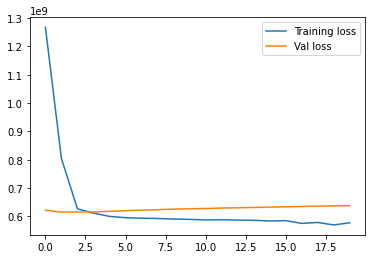

In [44]:
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

517/517 [==============================] - 3s 6ms/step - loss: 750665920.0000 - mean_squared_error: 750665920.0000
score 750665920.00
score 750665920.00
517/517 [==============================] - 2s 4ms/step
R2 Score:  -0.24043752542405716
MAE:  23114.588547574487


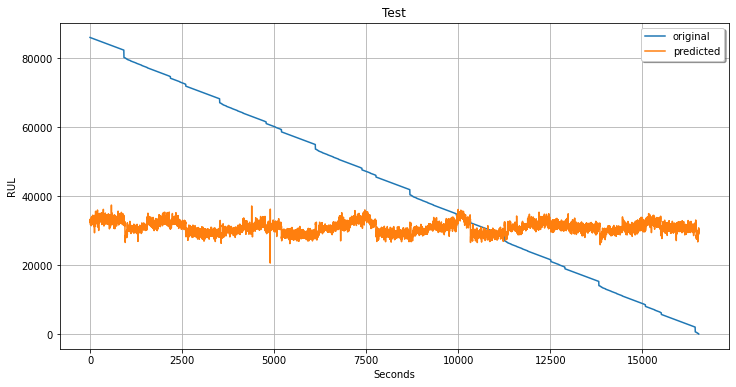

In [52]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

score, acc, = model1.evaluate(test_X, df_stream_yTest_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred = model1.predict(test_X)
print('R2 Score: ', r2_score(df_stream_yTest_LSTM, y_pred))
print('MAE: ', mean_absolute_error(df_stream_yTest_LSTM, y_pred))

x_ax = range(len(df_stream_yTest_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yTest_LSTM, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

1375/1375 [==============================] - 4s 3ms/step - loss: 637684608.0000 - mean_squared_error: 637684608.0000
score 637684608.00
score 637684608.00
1375/1375 [==============================] - 3s 2ms/step
R2 Score:  -0.04177395144907736
MAE:  21716.313758124845


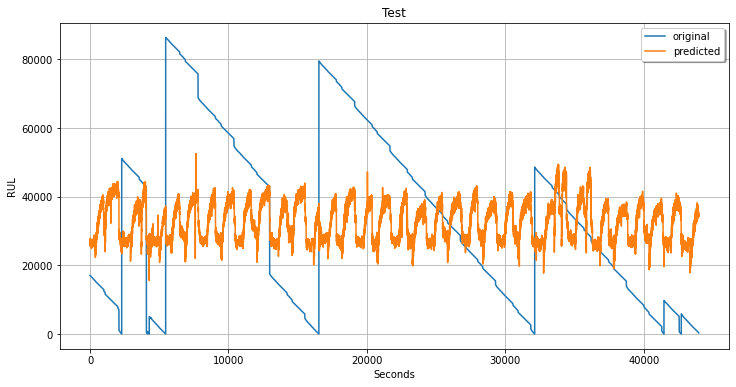

In [53]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

score, acc, = model1.evaluate(val_X, df_stream_yVal_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred_val = model1.predict(val_X)
print('R2 Score: ', r2_score(df_stream_yVal_LSTM, y_pred_val))
print('MAE: ', mean_absolute_error(df_stream_yVal_LSTM, y_pred_val))

x_ax = range(len(df_stream_yVal_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yVal_LSTM, label="original")
plt.plot(x_ax, y_pred_val, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

5497/5497 [==============================] - 14s 2ms/step - loss: 649519232.0000 - mean_squared_error: 649519232.0000
score 649519232.00
score 649519232.00
5497/5497 [==============================] - 12s 2ms/step
R2 Score:  0.05295174067522146
MAE:  21631.307591635858


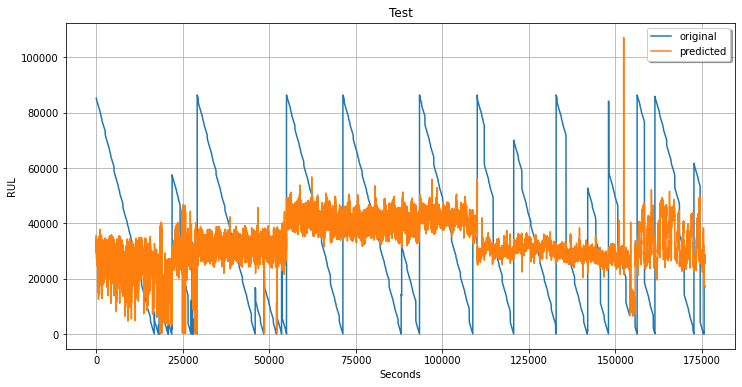

In [54]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

score, acc, = model1.evaluate(train_X, df_stream_yTrain_LSTM)
print('score %.2f'%score)
print('score %.2f'%acc)

y_pred_train = model1.predict(train_X)
print('R2 Score: ', r2_score(df_stream_yTrain_LSTM, y_pred_train))
print('MAE: ', mean_absolute_error(df_stream_yTrain_LSTM, y_pred_train))

x_ax = range(len(df_stream_yTrain_LSTM))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_yTrain_LSTM, label="original")
plt.plot(x_ax, y_pred_train, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

# RFR

In [ ]:
#next, regression
RFR = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features='sqrt', oob_score=True)
RFR.fit(df_stream_xTrain, df_stream_train['TTF_FlowCool Pressure Dropped Below Limit'])
y_prediction = RFR.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'],y_prediction)
print('r2 score is:',score)
print('mean_sqrd_error is:',mean_squared_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -0.9451675149808199
mean_sqrd_error is: 4975305486.522319
root_mean_squared error of is: 70535.84540162767


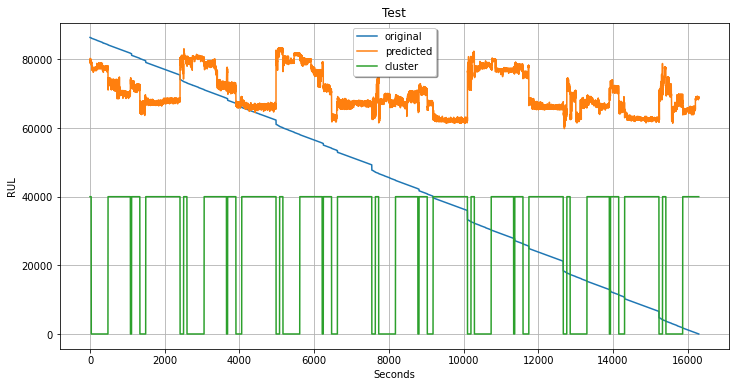

In [ ]:
x_ax = range(len(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'], label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.plot(x_ax, (cluster_pred * 40000), label="cluster")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

In [ ]:
j = np.where(y_pred_stream == 1)
for i in range(len(j[0])):
    display(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'].iloc[[j[0][i]]])

2875761    80292.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875762    80288.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875763    80284.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875764    80280.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875765    80276.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875766    80272.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875767    80268.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875768    80264.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875769    80260.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875770    80256.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875771    80252.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875772    80248.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875773    80244.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875774    80240.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875775    80236.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875776    80232.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875777    80228.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875778    80224.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875779    80220.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875780    80216.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875781    80212.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875782    80208.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875783    80204.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875784    80200.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875785    80196.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875786    80192.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875787    80188.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875788    80184.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875789    80180.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875790    80176.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875800    80136.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875801    80132.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875802    80128.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875803    80124.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875804    80120.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875805    80116.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875806    80112.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875807    80108.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875808    80104.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875809    80100.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875810    80096.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875811    80092.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875812    80088.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875813    80084.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875814    80080.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875827    80028.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875828    80024.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875829    80020.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875830    80016.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875831    80012.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875832    80008.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875833    80004.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875834    80000.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875835    79996.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875836    79992.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875837    79988.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875838    79984.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875839    79980.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875840    79976.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875841    79972.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875852    79928.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875853    79924.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875854    79920.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875855    79916.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875856    79912.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875857    79908.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875858    79904.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875859    79900.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875860    79896.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875861    79892.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875862    79888.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875863    79884.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875864    79880.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875865    79876.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875866    79872.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875879    79820.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875880    79816.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875881    79812.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875882    79808.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875883    79804.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875884    79800.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875885    79796.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875886    79792.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875887    79788.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875888    79784.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875889    79780.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875890    79776.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875891    79772.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875892    79768.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875893    79764.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875894    79760.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875895    79756.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875896    79752.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875897    79748.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2875898    79744.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2876021    79252.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2876022    79248.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2876023    79244.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2876024    79240.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2876025    79236.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2876026    79232.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2876027    79228.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2876028    79224.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2876029    79220.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2876030    79216.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2876031    79212.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878810    67052.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878830    66972.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878856    66868.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878857    66864.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878858    66860.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878859    66856.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878860    66852.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878861    66848.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878862    66844.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878863    66840.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878864    66836.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878865    66832.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878866    66828.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878867    66824.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878868    66820.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878869    66816.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878870    66812.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878880    66772.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878881    66768.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878882    66764.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878883    66760.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878884    66756.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878885    66752.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878886    66748.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878887    66744.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878888    66740.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878889    66736.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878890    66732.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878891    66728.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878892    66724.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878893    66720.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878894    66716.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878908    66660.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878909    66656.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878910    66652.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878911    66648.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878912    66644.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878913    66640.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878914    66636.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878915    66632.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878916    66628.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878917    66624.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878918    66620.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878919    66616.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878920    66612.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878921    66608.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878922    66604.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878923    66600.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878924    66596.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878925    66592.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878926    66588.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2878927    66584.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879210    65452.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879211    65448.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879212    65444.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879213    65440.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879214    65436.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879215    65432.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879216    65428.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879217    65424.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879218    65420.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879219    65416.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879220    65412.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879221    65408.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879222    65404.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879223    65400.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879224    65396.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879225    65392.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879226    65388.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879227    65384.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879228    65380.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879229    65376.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879230    65372.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879231    65368.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879232    65364.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879233    65360.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879234    65356.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879235    65352.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879236    65348.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879237    65344.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879238    65340.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879239    65336.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879240    65332.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879241    65328.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879242    65324.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879243    65320.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879244    65316.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879245    65312.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879246    65308.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879247    65304.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879248    65300.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879249    65296.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879250    65292.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879251    65288.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879252    65284.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879253    65280.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879254    65276.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879255    65272.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879256    65268.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879257    65264.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879258    65260.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879259    65256.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879260    65252.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879261    65248.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879262    65244.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879263    65240.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879264    65236.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879265    65232.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879266    65228.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879267    65224.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879268    65220.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879269    65216.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879270    65212.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879271    65208.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879272    65204.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879273    65200.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879274    65196.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879275    65192.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879276    65188.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879277    65184.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879278    65180.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879279    65176.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879280    65172.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879281    65168.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879282    65164.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879283    65160.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879284    65156.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879285    65152.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879286    65148.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879287    65144.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879288    65140.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879289    65136.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879290    65132.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879291    65128.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879292    65124.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879293    65120.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879294    65116.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879295    65112.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879296    65108.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879297    65104.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879298    65100.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879299    65096.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879300    65092.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879301    65088.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879302    65084.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879303    65080.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879304    65076.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879305    65072.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879306    65068.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879307    65064.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879308    65060.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879309    65056.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879310    65052.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879311    65048.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879312    65044.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879313    65040.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879314    65036.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879315    65032.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879316    65028.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879317    65024.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879318    65020.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879319    65016.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879320    65012.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879321    65008.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879322    65004.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879323    65000.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879324    64996.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879325    64992.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879326    64988.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879327    64984.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879328    64980.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879329    64976.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879330    64972.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879331    64968.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879332    64964.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879333    64960.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879334    64956.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879335    64952.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879336    64948.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879337    64944.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879338    64940.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879339    64936.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879340    64932.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879341    64928.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879342    64924.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879343    64920.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879344    64916.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879345    64912.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879346    64908.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879347    64904.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879348    64900.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879349    64896.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879350    64892.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879351    64888.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879352    64884.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879353    64880.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879354    64876.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879355    64872.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879356    64868.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879357    64864.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879358    64860.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879359    64856.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879376    64788.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879377    64784.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879378    64780.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879379    64776.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879380    64772.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879381    64768.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879382    64764.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879383    64760.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879384    64756.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879385    64752.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879386    64748.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879387    64744.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879388    64740.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879389    64736.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879390    64732.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879391    64728.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879392    64724.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879393    64720.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879394    64716.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879395    64712.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879396    64708.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879397    64704.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879398    64700.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879399    64696.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879400    64692.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879401    64688.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879402    64684.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879403    64680.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879404    64676.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879405    64672.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879406    64668.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879407    64664.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879408    64660.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879409    64656.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879410    64652.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879411    64648.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879412    64644.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879413    64640.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879414    64636.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879415    64632.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879416    64628.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879417    64624.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879418    64620.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879419    64616.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879420    64612.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879421    64608.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879422    64604.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879423    64600.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879424    64596.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879425    64592.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879426    64588.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879427    64584.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879428    64580.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879429    64576.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879430    64572.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879431    64568.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879432    64564.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879433    64560.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879434    64556.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879435    64552.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879436    64548.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879437    64544.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879438    64540.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879439    64536.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879440    64532.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879441    64528.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879442    64524.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879443    64520.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879444    64516.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879445    64512.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879446    64508.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879447    64504.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879448    64500.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879449    64496.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879450    64492.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879451    64488.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879452    64484.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879453    64480.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879454    64476.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879455    64472.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879456    64468.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879457    64464.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879458    64460.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879459    64456.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879460    64452.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879461    64448.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879462    64444.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879463    64440.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879464    64436.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879465    64432.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879466    64428.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879467    64424.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879468    64420.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879469    64416.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879470    64412.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879471    64408.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879472    64404.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879473    64400.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879474    64396.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879475    64392.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879476    64388.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879477    64384.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879478    64380.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879479    64376.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879480    64372.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879481    64368.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879482    64364.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879483    64360.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879484    64356.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879485    64352.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879486    64348.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879487    64344.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879488    64340.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879489    64336.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879490    64332.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879491    64328.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879492    64324.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879493    64320.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879494    64316.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879495    64312.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879496    64308.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879497    64304.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879498    64300.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879499    64296.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879500    64292.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879501    64288.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879502    64284.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879503    64280.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879504    64276.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879505    64272.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879506    64268.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879507    64264.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879508    64260.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879509    64256.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879510    64252.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879511    64248.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879512    64244.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879513    64240.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879514    64236.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879515    64232.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879516    64228.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879517    64224.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879518    64220.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879519    64216.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879520    64212.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879521    64208.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879522    64204.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879523    64200.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879524    64196.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2879525    64192.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881883    53424.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881884    53420.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881885    53416.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881886    53412.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881887    53408.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881888    53404.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881889    53400.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881890    53396.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881891    53392.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881892    53388.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881893    53384.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881894    53380.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881895    53376.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881896    53372.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881897    53368.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881908    53324.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881909    53320.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881910    53316.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881911    53312.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881912    53308.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881913    53304.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881914    53300.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881915    53296.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881916    53292.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881917    53288.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881918    53284.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881919    53280.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881920    53276.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881921    53272.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881922    53268.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881936    53212.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881937    53208.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881938    53204.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881939    53200.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881940    53196.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881941    53192.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881942    53188.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881943    53184.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881944    53180.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881945    53176.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881946    53172.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881947    53168.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881948    53164.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881949    53160.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881950    53156.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881951    53152.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2881952    53148.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2882077    52648.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2882079    52640.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2882080    52636.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2882081    52632.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2882082    52628.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2882083    52624.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2882084    52620.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2882086    52612.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884796    40428.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884797    40424.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884798    40420.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884799    40416.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884800    40412.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884801    40408.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884802    40404.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884803    40400.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884804    40396.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884805    40392.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884806    40388.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884807    40384.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884808    40380.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884809    40376.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884810    40372.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884811    40368.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884812    40364.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884813    40360.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884814    40356.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884815    40352.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884816    40348.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884817    40344.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884818    40340.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884819    40336.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884820    40332.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884821    40328.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884822    40324.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884823    40320.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884824    40316.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884825    40312.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884835    40272.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884836    40268.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884837    40264.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884838    40260.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884839    40256.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884840    40252.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884841    40248.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884842    40244.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884843    40240.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884844    40236.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884845    40232.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884846    40228.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884847    40224.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884848    40220.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884849    40216.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884862    40164.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884863    40160.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884864    40156.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884865    40152.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884866    40148.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884867    40144.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884868    40140.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884869    40136.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884870    40132.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884871    40128.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884872    40124.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884873    40120.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884874    40116.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884875    40112.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884876    40108.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884886    40068.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884887    40064.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884888    40060.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884889    40056.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884890    40052.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884891    40048.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884892    40044.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884893    40040.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884894    40036.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884895    40032.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884896    40028.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884897    40024.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884898    40020.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884899    40016.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884900    40012.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884915    39952.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884916    39948.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884917    39944.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884918    39940.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884919    39936.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884920    39932.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884921    39928.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884922    39924.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884923    39920.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884924    39916.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884925    39912.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884926    39908.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884927    39904.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884928    39900.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884929    39896.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884930    39892.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884931    39888.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884932    39884.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884933    39880.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2884934    39876.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885056    39388.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885057    39384.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885058    39380.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885059    39376.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885060    39372.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885061    39368.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885062    39364.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885063    39360.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885064    39356.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885065    39352.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885066    39348.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885067    39344.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885068    39340.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885069    39336.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885070    39332.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885071    39328.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885072    39324.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885073    39320.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885074    39316.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885075    39312.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885076    39308.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885077    39304.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885078    39300.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885079    39296.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885080    39292.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885081    39288.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885082    39284.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885083    39280.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885084    39276.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885085    39272.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885086    39268.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885087    39264.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885088    39260.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885089    39256.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885090    39252.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885091    39248.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885092    39244.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885093    39240.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885094    39236.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885095    39232.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885096    39228.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885097    39224.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885098    39220.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885099    39216.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885100    39212.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885101    39208.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885102    39204.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885103    39200.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885104    39196.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885105    39192.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885106    39188.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885107    39184.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885108    39180.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885109    39176.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885110    39172.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885111    39168.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885112    39164.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885113    39160.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885114    39156.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885116    39148.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885117    39144.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885118    39140.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885119    39136.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885120    39132.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885123    39120.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885124    39116.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885125    39112.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885126    39108.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885127    39104.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885128    39100.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885129    39096.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885130    39092.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885131    39088.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885132    39084.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885133    39080.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885134    39076.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885135    39072.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885136    39068.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885137    39064.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885138    39060.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885139    39056.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885140    39052.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885141    39048.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885144    39036.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885145    39032.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885147    39024.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885148    39020.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885149    39016.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885152    39004.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885153    39000.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885155    38992.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885156    38988.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885159    38976.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885160    38972.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885162    38964.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885165    38952.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885168    38940.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885171    38928.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885173    38920.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885174    38916.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885183    38880.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885189    38856.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885190    38852.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885191    38848.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885192    38844.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885195    38832.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885204    38796.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885216    38748.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885217    38744.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885218    38740.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885219    38736.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885220    38732.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885221    38728.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885222    38724.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885223    38720.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885224    38716.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885225    38712.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885226    38708.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885227    38704.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885228    38700.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885229    38696.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885230    38692.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885231    38688.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885232    38684.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885233    38680.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885234    38676.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885235    38672.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885236    38668.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885237    38664.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885238    38660.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885239    38656.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885240    38652.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885241    38648.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885242    38644.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885243    38640.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885244    38636.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885245    38632.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885246    38628.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885247    38624.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885248    38620.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885249    38616.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885250    38612.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885251    38608.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885252    38604.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885253    38600.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885254    38596.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885255    38592.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885256    38588.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885257    38584.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885258    38580.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885259    38576.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885260    38572.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885261    38568.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885262    38564.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885263    38560.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885264    38556.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885265    38552.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885266    38548.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885267    38544.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885268    38540.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885269    38536.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885270    38532.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885271    38528.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885272    38524.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885273    38520.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885274    38516.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885275    38512.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885276    38508.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885277    38504.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885278    38500.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885279    38496.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885280    38492.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885281    38488.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885282    38484.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885283    38480.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885284    38476.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885285    38472.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885286    38468.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885287    38464.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885288    38460.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885289    38456.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885290    38452.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885291    38448.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885292    38444.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885293    38440.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885294    38436.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885295    38432.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885296    38428.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885297    38424.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885298    38420.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885299    38416.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885300    38412.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885301    38408.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885302    38404.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885303    38400.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885304    38396.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885305    38392.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885306    38388.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885307    38384.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885308    38380.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885309    38376.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885310    38372.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885311    38368.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885312    38364.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885313    38360.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885314    38356.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885315    38352.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885316    38348.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885317    38344.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885318    38340.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885319    38336.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885320    38332.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885321    38328.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885322    38324.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885323    38320.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885324    38316.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885325    38312.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885326    38308.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885327    38304.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885328    38300.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885329    38296.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885330    38292.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885331    38288.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885332    38284.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885333    38280.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885334    38276.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885335    38272.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885336    38268.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885337    38264.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885338    38260.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885339    38256.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885340    38252.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885341    38248.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885342    38244.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885343    38240.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885344    38236.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885345    38232.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885346    38228.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885347    38224.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885348    38220.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885349    38216.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885350    38212.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885351    38208.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885352    38204.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885353    38200.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885354    38196.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885355    38192.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885356    38188.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885357    38184.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885358    38180.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885359    38176.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885360    38172.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885361    38168.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885362    38164.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885363    38160.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885364    38156.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885365    38152.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885382    38084.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885383    38080.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885384    38076.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885385    38072.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885386    38068.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885387    38064.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885388    38060.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885389    38056.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885390    38052.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885391    38048.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885392    38044.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885393    38040.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885394    38036.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885395    38032.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885396    38028.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885397    38024.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885398    38020.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885399    38016.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885400    38012.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885401    38008.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885402    38004.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885403    38000.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885404    37996.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885405    37992.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885406    37988.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885407    37984.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885408    37980.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885409    37976.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885410    37972.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885411    37968.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885412    37964.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885413    37960.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885414    37956.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885415    37952.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885416    37948.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885417    37944.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885418    37940.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885419    37936.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885420    37932.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885421    37928.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885422    37924.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885423    37920.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885424    37916.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885425    37912.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885426    37908.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885427    37904.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885428    37900.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885429    37896.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885430    37892.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885431    37888.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885432    37884.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885433    37880.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885434    37876.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885435    37872.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885436    37868.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885437    37864.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885438    37860.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885439    37856.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885440    37852.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885441    37848.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885442    37844.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885443    37840.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885444    37836.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885445    37832.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885446    37828.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885447    37824.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885448    37820.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885449    37816.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885450    37812.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885451    37808.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885452    37804.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885453    37800.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885454    37796.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885455    37792.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885456    37788.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885457    37784.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885458    37780.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885459    37776.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885460    37772.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885461    37768.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885462    37764.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885463    37760.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885464    37756.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885465    37752.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885466    37748.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885467    37744.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885468    37740.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885469    37736.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885470    37732.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885471    37728.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885472    37724.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885473    37720.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885474    37716.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885475    37712.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885476    37708.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885477    37704.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885478    37700.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885479    37696.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885480    37692.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885481    37688.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885482    37684.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885483    37680.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885484    37676.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885485    37672.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885486    37668.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885487    37664.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885488    37660.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885489    37656.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885490    37652.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885491    37648.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885492    37644.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885493    37640.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885494    37636.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885495    37632.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885496    37628.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885497    37624.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885498    37620.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885499    37616.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885500    37612.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885501    37608.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885502    37604.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885503    37600.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885504    37596.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885505    37592.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885506    37588.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885507    37584.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885508    37580.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885509    37576.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885510    37572.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885511    37568.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885512    37564.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885513    37560.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885514    37556.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885515    37552.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885516    37548.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885517    37544.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885518    37540.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885519    37536.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885520    37532.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885521    37528.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885522    37524.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885523    37520.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885524    37516.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885525    37512.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885526    37508.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885527    37504.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885528    37500.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885529    37496.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885530    37492.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2885531    37488.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886168    34940.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886169    34936.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886171    34928.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886172    34924.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886173    34920.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886174    34916.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886175    34912.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886176    34908.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886177    34904.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886178    34900.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886179    34896.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886180    34892.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886181    34888.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886182    34884.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886183    34880.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886184    34876.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886185    34872.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886186    34868.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886187    34864.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886188    34860.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886189    34856.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886190    34852.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886191    34848.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2886192    34844.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887776    27072.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887777    27068.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887778    27064.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887779    27060.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887780    27056.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887781    27052.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887782    27048.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887783    27044.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887784    27040.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887785    27036.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887786    27032.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887787    27028.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887788    27024.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887789    27020.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887790    27016.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887791    27012.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887792    27008.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887793    27004.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887794    27000.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887795    26996.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887796    26992.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887797    26988.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887798    26984.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887799    26980.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887800    26976.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887801    26972.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887802    26968.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887803    26964.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887804    26960.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887805    26956.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887815    26916.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887816    26912.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887817    26908.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887818    26904.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887819    26900.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887820    26896.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887821    26892.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887822    26888.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887823    26884.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887824    26880.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887825    26876.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887826    26872.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887827    26868.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887828    26864.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887829    26860.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887842    26808.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887843    26804.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887844    26800.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887845    26796.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887846    26792.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887847    26788.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887848    26784.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887849    26780.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887850    26776.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887851    26772.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887852    26768.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887853    26764.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887854    26760.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887855    26756.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887856    26752.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887867    26708.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887868    26704.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887869    26700.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887870    26696.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887871    26692.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887872    26688.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887873    26684.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887874    26680.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887875    26676.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887876    26672.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887877    26668.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887878    26664.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887879    26660.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887880    26656.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887895    26596.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887896    26592.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887897    26588.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887898    26584.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887899    26580.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887900    26576.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887901    26572.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887902    26568.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887903    26564.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887904    26560.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887905    26556.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887906    26552.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887908    26544.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2887912    26528.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2888036    26032.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2888037    26028.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2888038    26024.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2888039    26020.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2888040    26016.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2888041    26012.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2888042    26008.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2888043    26004.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2888044    26000.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890761    14024.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890801    13864.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890819    13792.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890820    13788.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890821    13784.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890822    13780.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890823    13776.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890824    13772.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890825    13768.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890826    13764.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890827    13760.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890828    13756.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890829    13752.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890830    13748.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890831    13744.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890832    13740.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890833    13736.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890843    13696.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890844    13692.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890845    13688.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890846    13684.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890847    13680.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890848    13676.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890849    13672.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890850    13668.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890851    13664.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890852    13660.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890853    13656.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890854    13652.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890855    13648.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890856    13644.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890857    13640.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890871    13584.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890872    13580.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890873    13576.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890874    13572.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890875    13568.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890876    13564.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890877    13560.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890878    13556.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890879    13552.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890880    13548.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890881    13544.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890882    13540.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890883    13536.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890884    13532.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890885    13528.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890886    13524.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890887    13520.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890888    13516.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890889    13512.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2890890    13508.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891126    12564.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891146    12484.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891173    12376.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891174    12372.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891175    12368.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891176    12364.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891177    12360.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891178    12356.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891179    12352.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891180    12348.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891181    12344.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891182    12340.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891183    12336.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891184    12332.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891185    12328.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891186    12324.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891187    12320.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891188    12316.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891189    12312.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891190    12308.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891191    12304.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891192    12300.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891193    12296.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891194    12292.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891195    12288.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891196    12284.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891197    12280.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891198    12276.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891199    12272.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891200    12268.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891201    12264.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891202    12260.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891203    12256.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891204    12252.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891205    12248.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891206    12244.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891207    12240.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891208    12236.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891209    12232.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891210    12228.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891211    12224.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891212    12220.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891213    12216.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891214    12212.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891215    12208.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891216    12204.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891217    12200.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891218    12196.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891219    12192.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891220    12188.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891221    12184.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891222    12180.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891223    12176.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891224    12172.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891225    12168.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891226    12164.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891227    12160.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891228    12156.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891229    12152.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891230    12148.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891231    12144.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891232    12140.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891233    12136.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891234    12132.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891235    12128.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891236    12124.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891237    12120.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891238    12116.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891239    12112.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891240    12108.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891241    12104.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891242    12100.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891243    12096.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891244    12092.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891245    12088.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891246    12084.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891247    12080.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891248    12076.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891249    12072.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891250    12068.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891251    12064.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891252    12060.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891253    12056.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891254    12052.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891255    12048.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891256    12044.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891257    12040.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891258    12036.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891259    12032.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891260    12028.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891261    12024.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891262    12020.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891263    12016.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891264    12012.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891265    12008.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891266    12004.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891267    12000.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891268    11996.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891269    11992.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891270    11988.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891271    11984.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891272    11980.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891273    11976.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891274    11972.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891275    11968.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891276    11964.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891277    11960.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891278    11956.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891279    11952.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891280    11948.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891281    11944.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891282    11940.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891283    11936.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891284    11932.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891285    11928.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891286    11924.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891287    11920.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891288    11916.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891289    11912.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891290    11908.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891291    11904.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891292    11900.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891293    11896.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891294    11892.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891295    11888.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891296    11884.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891297    11880.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891298    11876.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891299    11872.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891300    11868.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891301    11864.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891302    11860.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891303    11856.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891304    11852.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891305    11848.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891306    11844.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891307    11840.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891308    11836.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891309    11832.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891310    11828.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891311    11824.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891312    11820.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891313    11816.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891314    11812.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891315    11808.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891316    11804.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891317    11800.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891318    11796.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891319    11792.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891320    11788.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891321    11784.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891322    11780.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891339    11712.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891340    11708.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891341    11704.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891342    11700.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891343    11696.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891344    11692.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891345    11688.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891346    11684.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891347    11680.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891348    11676.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891349    11672.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891350    11668.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891351    11664.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891352    11660.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891353    11656.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891354    11652.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891355    11648.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891356    11644.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891357    11640.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891358    11636.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891359    11632.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891360    11628.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891361    11624.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891362    11620.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891363    11616.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891364    11612.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891365    11608.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891366    11604.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891367    11600.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891368    11596.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891369    11592.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891370    11588.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891371    11584.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891372    11580.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891373    11576.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891374    11572.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891375    11568.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891376    11564.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891377    11560.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891378    11556.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891379    11552.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891380    11548.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891381    11544.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891382    11540.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891383    11536.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891384    11532.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891385    11528.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891386    11524.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891387    11520.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891388    11516.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891389    11512.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891390    11508.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891391    11504.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891392    11500.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891393    11496.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891394    11492.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891395    11488.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891396    11484.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891397    11480.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891398    11476.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891399    11472.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891400    11468.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891401    11464.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891402    11460.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891403    11456.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891404    11452.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891405    11448.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891406    11444.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891407    11440.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891408    11436.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891409    11432.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891410    11428.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891411    11424.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891412    11420.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891413    11416.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891414    11412.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891415    11408.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891416    11404.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891417    11400.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891418    11396.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891419    11392.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891420    11388.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891421    11384.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891422    11380.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891423    11376.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891424    11372.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891425    11368.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891426    11364.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891427    11360.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891428    11356.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891429    11352.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891430    11348.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891431    11344.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891432    11340.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891433    11336.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891434    11332.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891435    11328.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891436    11324.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891437    11320.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891438    11316.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891439    11312.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891440    11308.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891441    11304.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891442    11300.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891443    11296.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891444    11292.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891445    11288.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891446    11284.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891447    11280.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891448    11276.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891449    11272.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891450    11268.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891451    11264.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891452    11260.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891453    11256.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891454    11252.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891455    11248.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891456    11244.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891457    11240.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891458    11236.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891459    11232.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891460    11228.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891461    11224.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891462    11220.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891463    11216.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891464    11212.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891465    11208.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891466    11204.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891467    11200.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891468    11196.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891469    11192.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891470    11188.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891471    11184.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891472    11180.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891473    11176.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891474    11172.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891475    11168.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891476    11164.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891477    11160.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891478    11156.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891479    11152.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891480    11148.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891481    11144.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891482    11140.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891483    11136.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891484    11132.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891485    11128.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891486    11124.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891487    11120.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2891488    11116.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893790    620.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893791    616.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893792    612.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893793    608.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893794    604.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893795    600.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893796    596.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893797    592.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893798    588.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893799    584.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893800    580.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893801    576.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893802    572.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893803    568.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893804    564.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893805    560.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893806    556.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893807    552.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893808    548.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893809    544.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893810    540.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893811    536.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893812    532.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893813    528.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893814    524.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893815    520.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893816    516.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893817    512.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893818    508.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893819    504.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893829    464.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893830    460.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893831    456.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893832    452.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893833    448.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893834    444.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893835    440.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893836    436.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893837    432.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893838    428.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893839    424.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893840    420.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893841    416.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893842    412.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893843    408.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893856    356.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893857    352.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893858    348.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893859    344.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893860    340.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893861    336.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893862    332.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893863    328.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893864    324.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893865    320.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893866    316.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893867    312.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893868    308.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893869    304.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893870    300.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893880    260.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893881    256.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893882    252.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893883    248.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893884    244.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893885    240.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893886    236.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893887    232.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893888    228.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893889    224.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893890    220.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893891    216.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893892    212.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893893    208.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893894    204.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893908    148.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893909    144.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893910    140.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893911    136.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893912    132.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893913    128.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893914    124.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893915    120.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893916    116.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893917    112.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893919    104.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893920    100.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893921    96.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

2893922    92.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64

# LASSO

In [ ]:
from sklearn.linear_model import Lasso

laso = Lasso()
laso.fit(df_stream_xTrain, df_stream_train['TTF_FlowCool Pressure Dropped Below Limit'])
y_prediction = laso.predict(df_stream_xTest)

score=r2_score(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'],y_prediction)
print('r2 score is:',score)
print('mean_sqrd_error is:',mean_squared_error(df_stream_yTest,y_prediction))
print('root_mean_squared error of is:',np.sqrt(mean_squared_error(df_stream_yTest,y_prediction)))

r2 score is: -0.3679511764085921
mean_sqrd_error is: 24010525188.13275
root_mean_squared error of is: 154953.30002337074


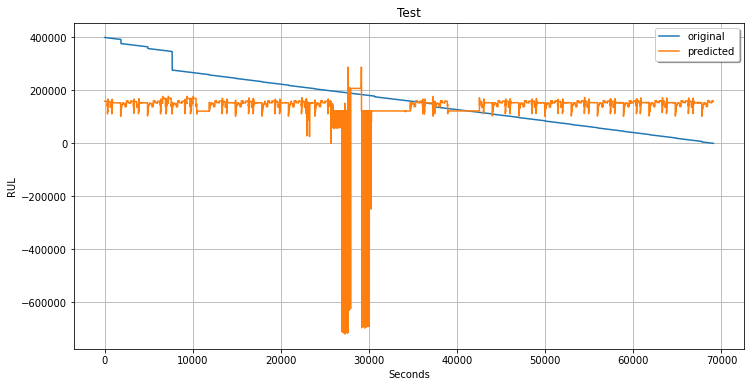

In [ ]:
x_ax = range(len(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'], label="original")
plt.plot(x_ax, y_prediction, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

# LIGHT GRADIENT BOOSTING

In [ ]:
#https://www.datatechnotes.com/2022/03/lightgbm-regression-example-in-python.html
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

lgb_train = lgb.Dataset(df_stream_xTrain, df_stream_train['TTF_FlowCool Pressure Dropped Below Limit'])
lgb_eval = lgb.Dataset(df_stream_xTest, df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'], reference=lgb_train)

model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

y_pred = model.predict(df_stream_xTest)

# accuracy check
mse = mean_squared_error(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'], y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

[1]	valid_0's l1: 4817.21	valid_0's l2: 3.11433e+07
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 4775.51	valid_0's l2: 3.0856e+07
[3]	valid_0's l1: 4773.5	valid_0's l2: 3.08409e+07
[4]	valid_0's l1: 4763.07	valid_0's l2: 3.07644e+07
[5]	valid_0's l1: 4779.2	valid_0's l2: 3.07397e+07
[6]	valid_0's l1: 4841.05	valid_0's l2: 3.1138e+07
[7]	valid_0's l1: 4860.35	valid_0's l2: 3.11167e+07
[8]	valid_0's l1: 4824.15	valid_0's l2: 3.09115e+07
[9]	valid_0's l1: 4843.66	valid_0's l2: 3.09234e+07
[10]	valid_0's l1: 4840.05	valid_0's l2: 3.09058e+07
[11]	valid_0's l1: 4831.98	valid_0's l2: 3.08667e+07
[12]	valid_0's l1: 4896.56	valid_0's l2: 3.12184e+07
[13]	valid_0's l1: 4868.85	valid_0's l2: 3.10704e+07
[14]	valid_0's l1: 4834.18	valid_0's l2: 3.10135e+07
[15]	valid_0's l1: 4998.67	valid_0's l2: 3.20165e+07
[16]	valid_0's l1: 5000.96	valid_0's l2: 3.20538e+07
[17]	valid_0's l1: 4986.35	valid_0's l2: 3.19985e+07
[18]	valid_0's l1: 4972.86	valid_0's l2: 3.19055e+

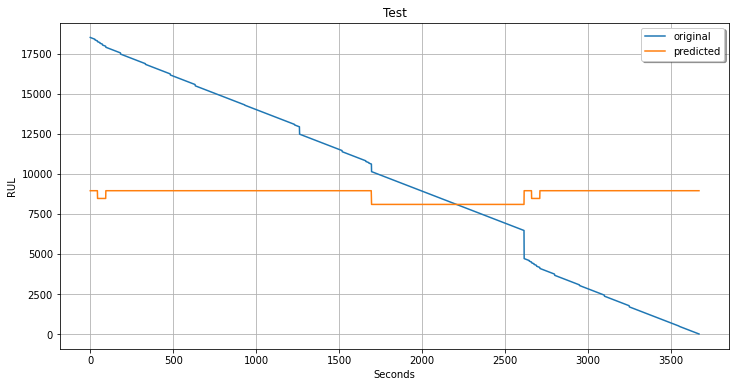

In [ ]:
x_ax = range(len(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit']))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'], label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test")
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

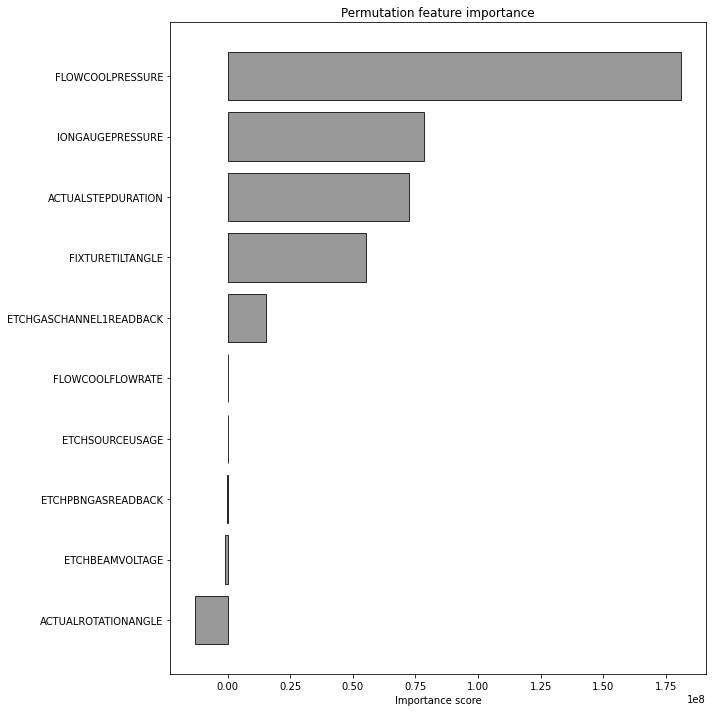

In [ ]:
imp = rfpimp.importances(RFR, df_stream_xTest, df_stream_yTest)

fig, ax = plt.subplots(figsize=(6, 3))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k') #find how to only see top 10 bars
ax.set_xlabel('Importance score')
ax.set_title('Permutation feature importance')
plt.gca().invert_yaxis()
fig.set_size_inches(10, 10)

fig.tight_layout()

# Loop

In [ ]:
#loop through the test data, inserting 1 row at a time
for i in range(len(df_stream_xTest)):
    #if the RFC predicts a fail with over 55% confidence
    predictions = RFC.predict_proba(df_stream_xTest.iloc[[i]])
    if predictions[0][1] > 0.50:
        #output the estimate of the regressor
        print("The regressor estimated a TTF of:" + str(RFR.predict(df_stream_xTest.iloc[[i]])[0]))
        print("The pred estimated a TTF of:" + str(y_prediction[i]))
        #versus the true TTF
        print(df_stream_test['TTF_FlowCool Pressure Dropped Below Limit'].iloc[[i]])
        #and the prediction that the RFC made
        print(predictions[0][1])
        print('--------------------------------------------------------')

The regressor estimated a TTF of:11204.88
The pred estimated a TTF of:11204.88
2901021    69796.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64
0.5066204034495961
--------------------------------------------------------
The regressor estimated a TTF of:12750.08
The pred estimated a TTF of:12750.08
2901022    69792.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64
0.5077189011056105
--------------------------------------------------------
The regressor estimated a TTF of:12532.68
The pred estimated a TTF of:12532.68
2901023    69788.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64
0.5077189011056106
--------------------------------------------------------
The regressor estimated a TTF of:13013.76
The pred estimated a TTF of:13013.76
2901024    69784.0
Name: TTF_FlowCool Pressure Dropped Below Limit, dtype: float64
0.5077189011056106
--------------------------------------------------------
The regressor estimated a TTF of:12801.28
The pr

KeyboardInterrupt: ignored